<a href="https://colab.research.google.com/github/Boliang312/Deep-Learning/blob/main/HW3_Chen_Boliang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [6]:
# Assuming df is your dataset
df = pd.read_csv('TSLA.csv')
df['Date'] = pd.to_datetime(df['Date'])
data = df.filter(['Close'])
data

,Close
0,51.830002
1,52.431999
2,53.130001
3,52.627998
4,53.335999
...,...
1254,241.731995
1255,274.316010
1256,277.971985
1257,273.175995


In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step):
    x_data, y_data = [], []
    for i in range(time_step, len(dataset)):
        x_data.append(dataset[i-time_step:i, 0])
        y_data.append(dataset[i, 0])
    return np.array(x_data), np.array(y_data)

In [8]:
# Define a function to build and train the model
def build_and_train_model(input_data, output_data, layers, batch_size, epochs=1):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(input_data.shape[1], 1)))
    for i in range(layers - 2):  # Adjusting for input and final dense layer
        model.add(LSTM(64, return_sequences=True if i != layers - 3 else False))  # Ensure the last LSTM layer doesn't return sequences
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs)
    return model

In [12]:
def visualize_predictions(train_data, valid_data, title):
    plt.figure(figsize=(16, 6))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train_data['Date'], train_data['Close'])
    plt.plot(valid_data['Date'], valid_data['Close'])
    plt.plot(valid_data['Date'], valid_data['Predictions'])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [13]:
# Create training datasets with different time lags
time_steps = [1, 7, 14]
layer_options = [4, 6]
batch_sizes = [32, 64]

40/40 [==============================] - 2s 3ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


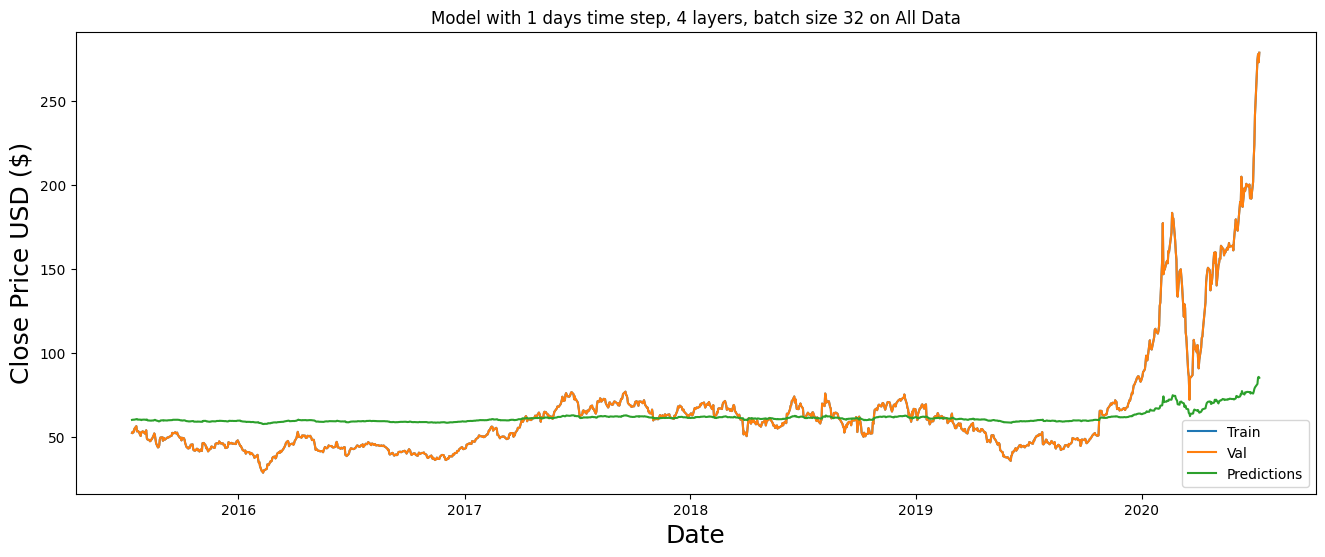

40/40 [==============================] - 1s 3ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


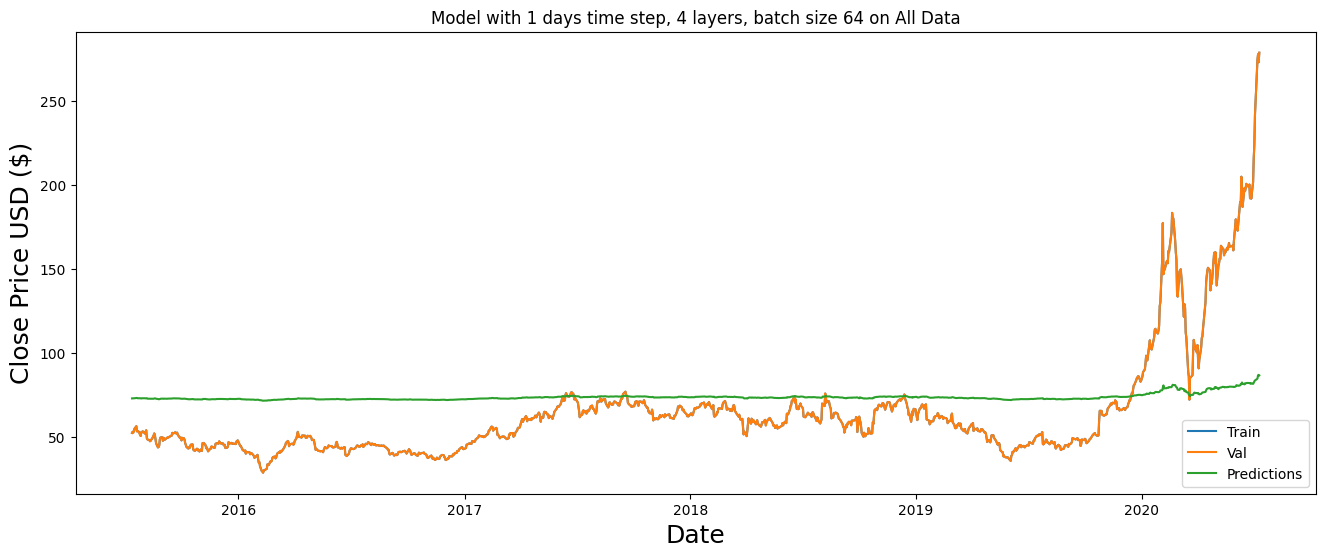

40/40 [==============================] - 2s 4ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


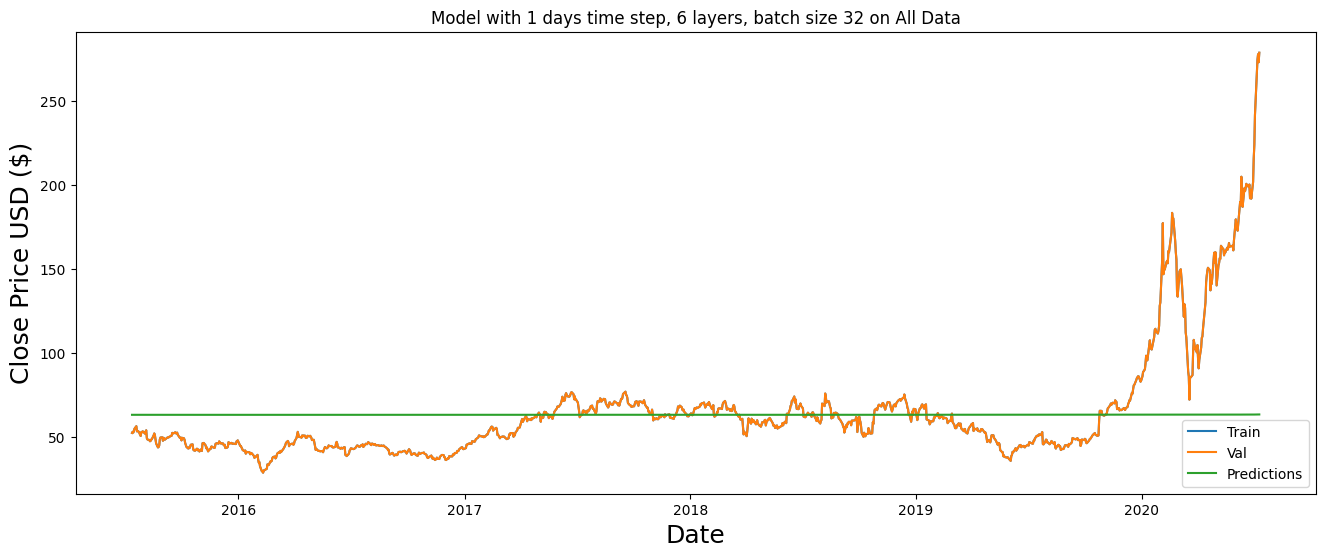

40/40 [==============================] - 2s 4ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


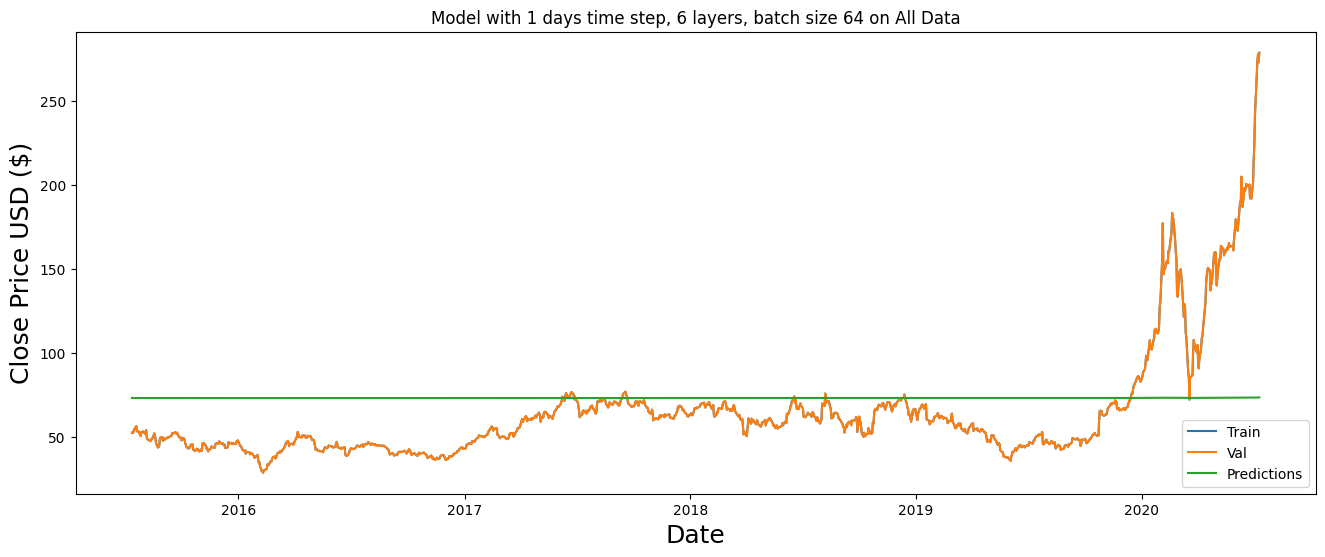

40/40 [==============================] - 1s 3ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


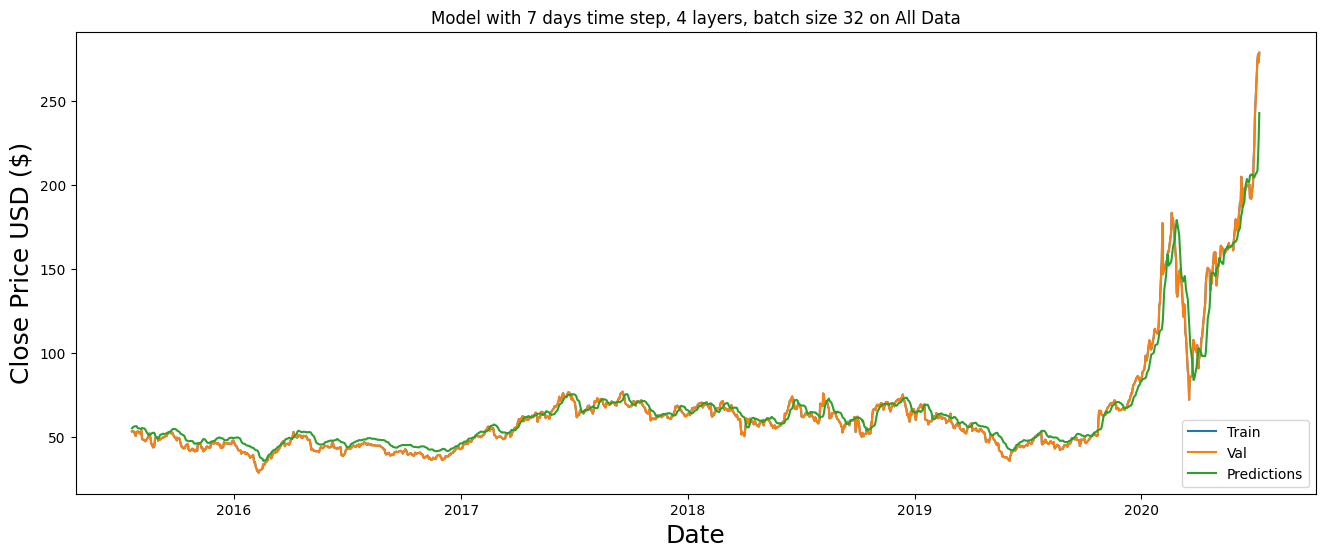

40/40 [==============================] - 3s 4ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


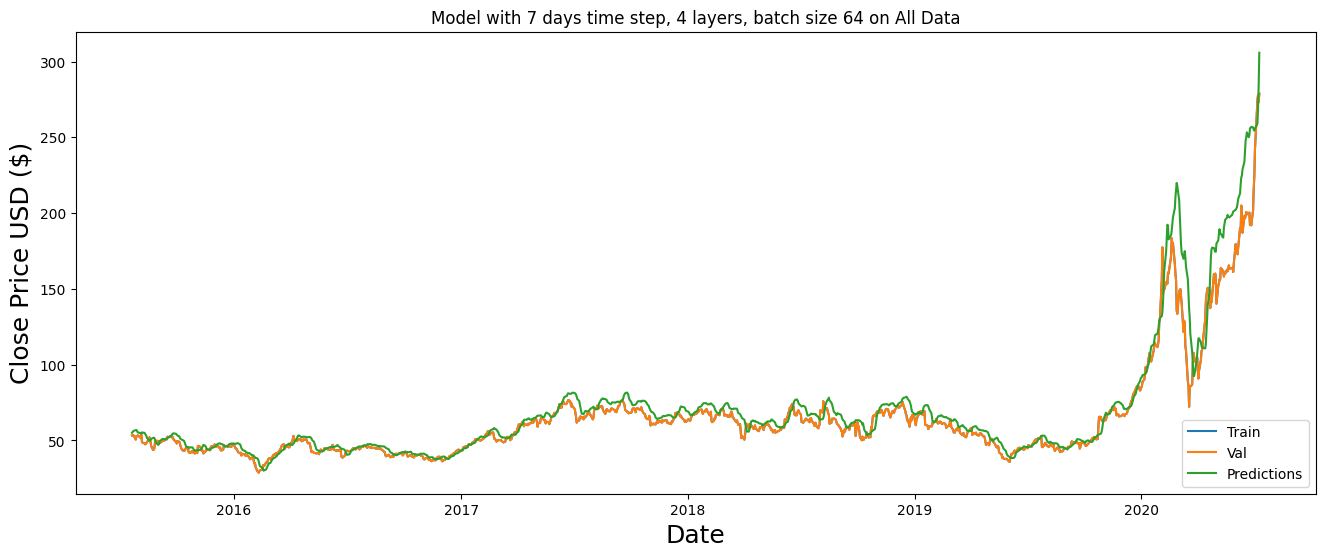

40/40 [==============================] - 2s 5ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


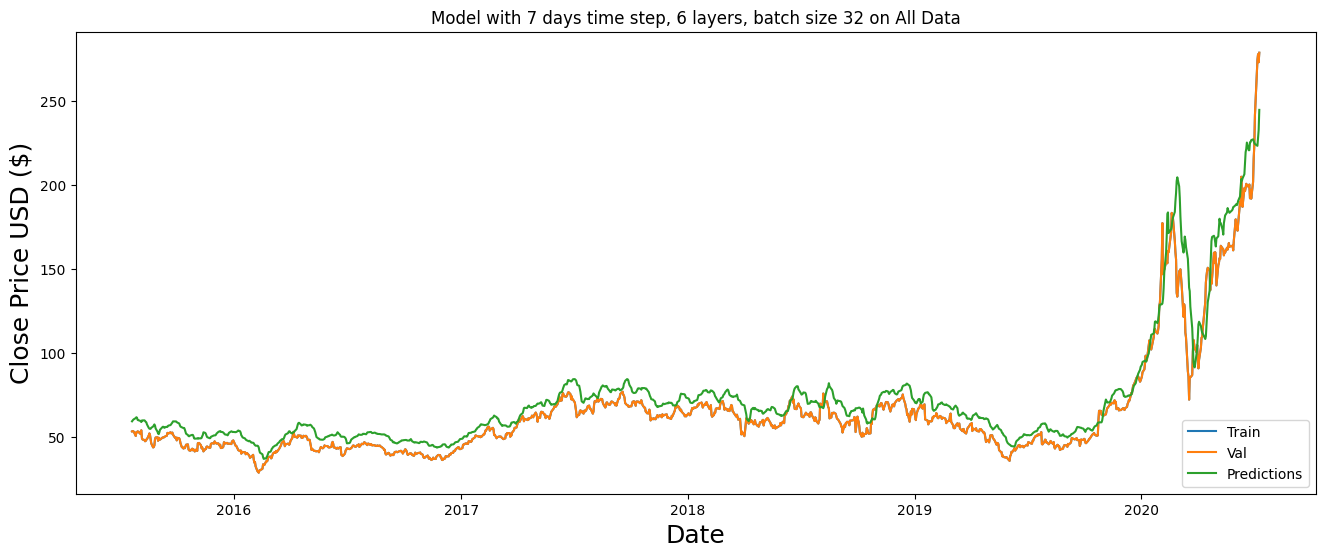

40/40 [==============================] - 2s 5ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


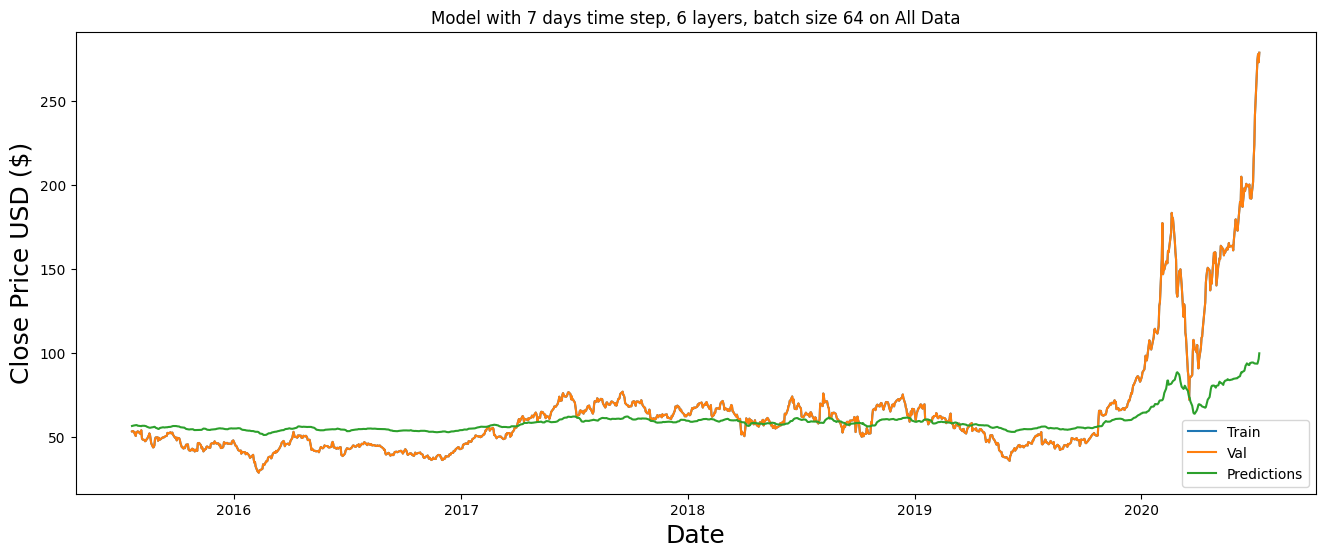

39/39 [==============================] - 1s 4ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


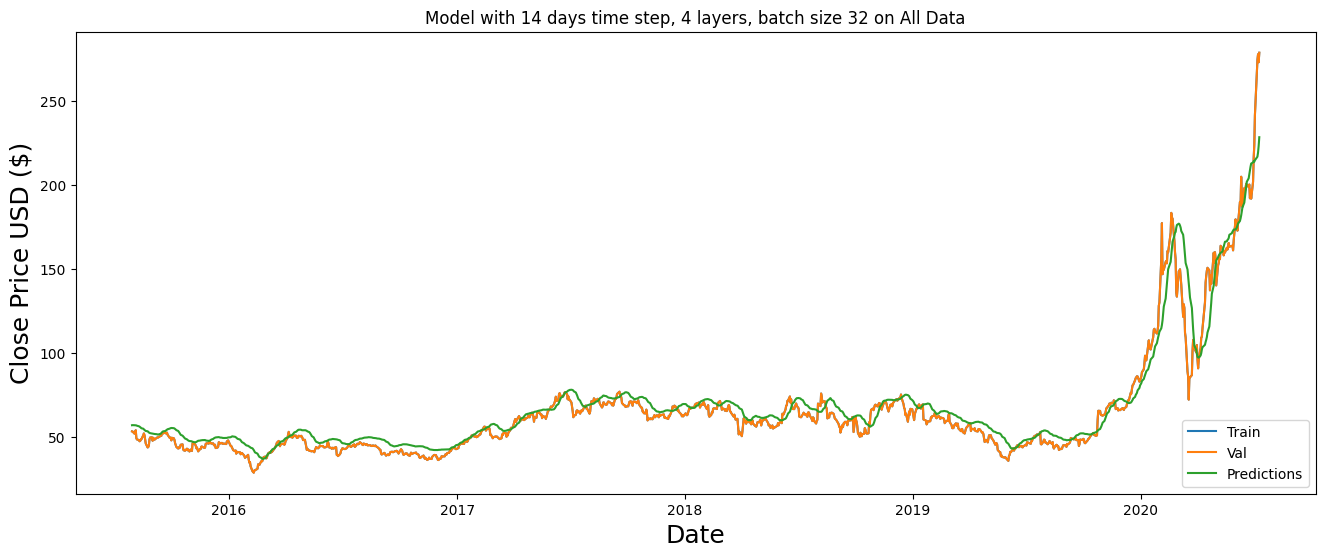

39/39 [==============================] - 1s 4ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


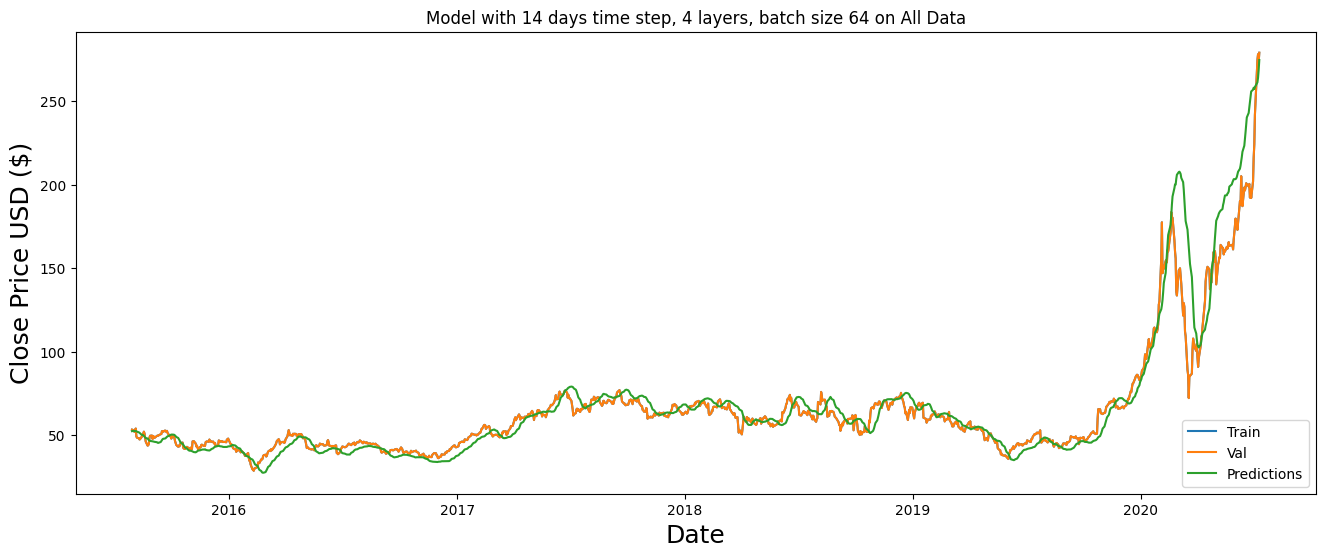

39/39 [==============================] - 2s 5ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


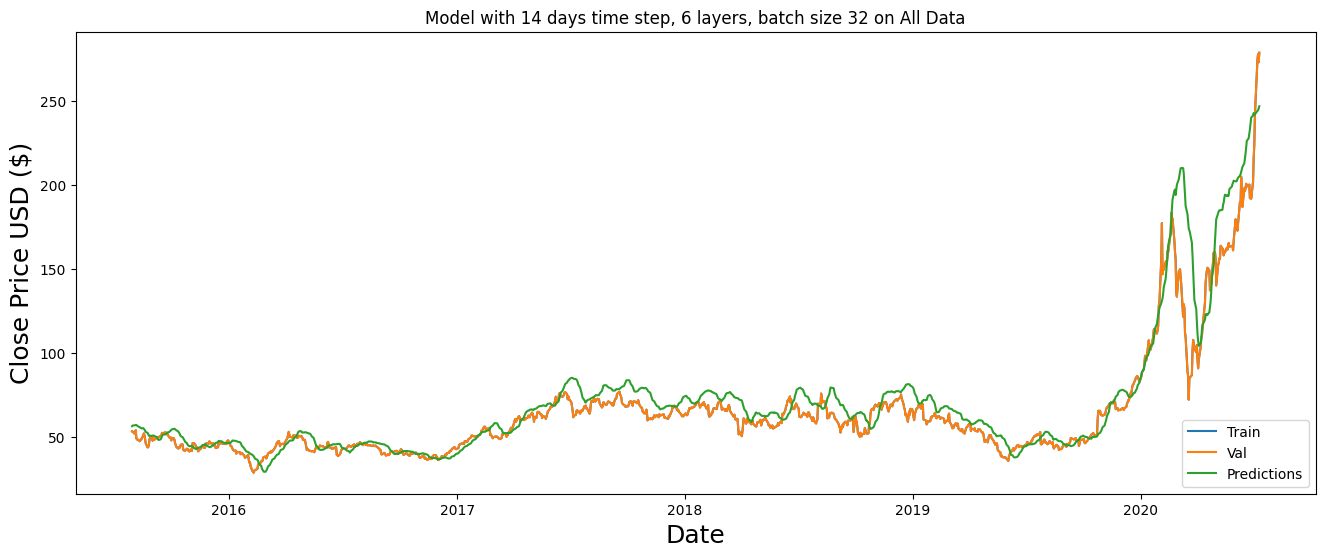

39/39 [==============================] - 2s 5ms/step


<ipython-input-20-d614d8d543e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Predictions'] = predictions


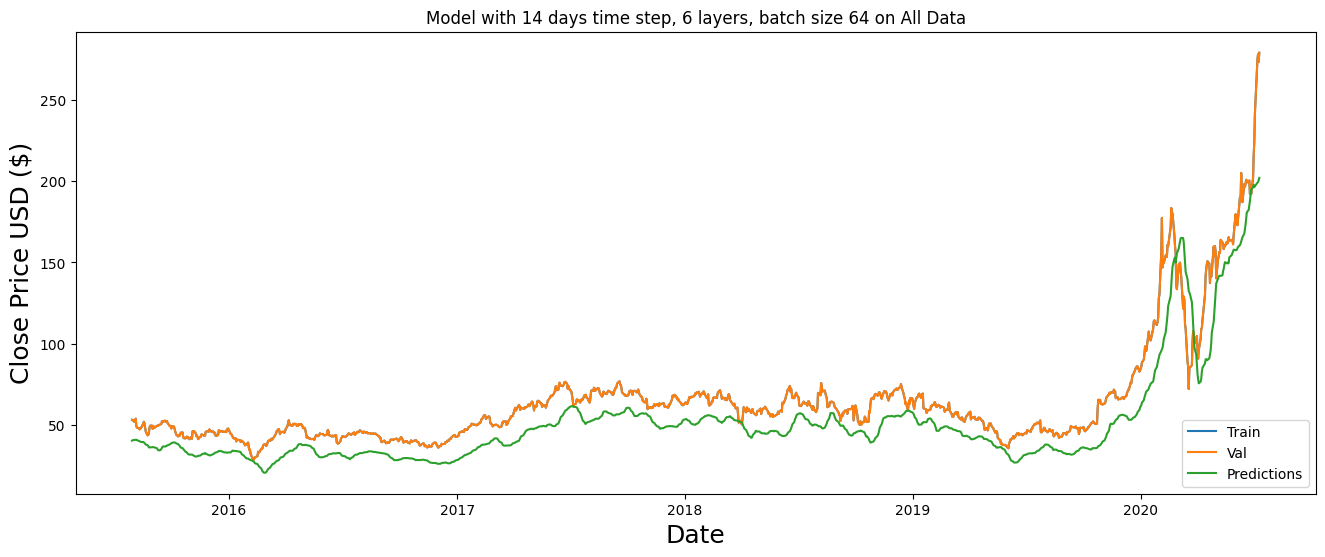

In [20]:
for step in time_steps:
    for layers in layer_options:
        for batch in batch_sizes:

            # Create datasets for all data
            x_all, y_all = create_dataset(scaled_data, step)

            # Reshape the data
            x_all = np.reshape(x_all, (x_all.shape[0], x_all.shape[1], 1))

            # Build and train the model on the entire dataset
            model = build_and_train_model(x_all, y_all, layers, batch, epochs=1)

            # Generate predictions for the entire dataset
            predictions = model.predict(x_all)
            predictions = scaler.inverse_transform(predictions)

            # Create a dataframe for visualization
            df_all = df[step:]  # Adjust the data to match the lag
            df_all['Predictions'] = predictions

            # Visualize the results
            visualize_predictions(df_all, df_all, f"Model with {step} days time step, {layers} layers, batch size {batch} on All Data")


In [ ]:
#Although the model with 14days, 4 layers, batch size 32 has the lowest loss, the model with 14days, 4 layers, 64 batch size has the nearest prediction close price to the real close price.

#So, I choose to use model with 14days, 4 layers, 64 batch size to do the future prediction.

1/1 [==============================] - 1s 926ms/step


<ipython-input-37-174de7bb1ea6>:32: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(latest_date, periods=period + 1, closed='right')


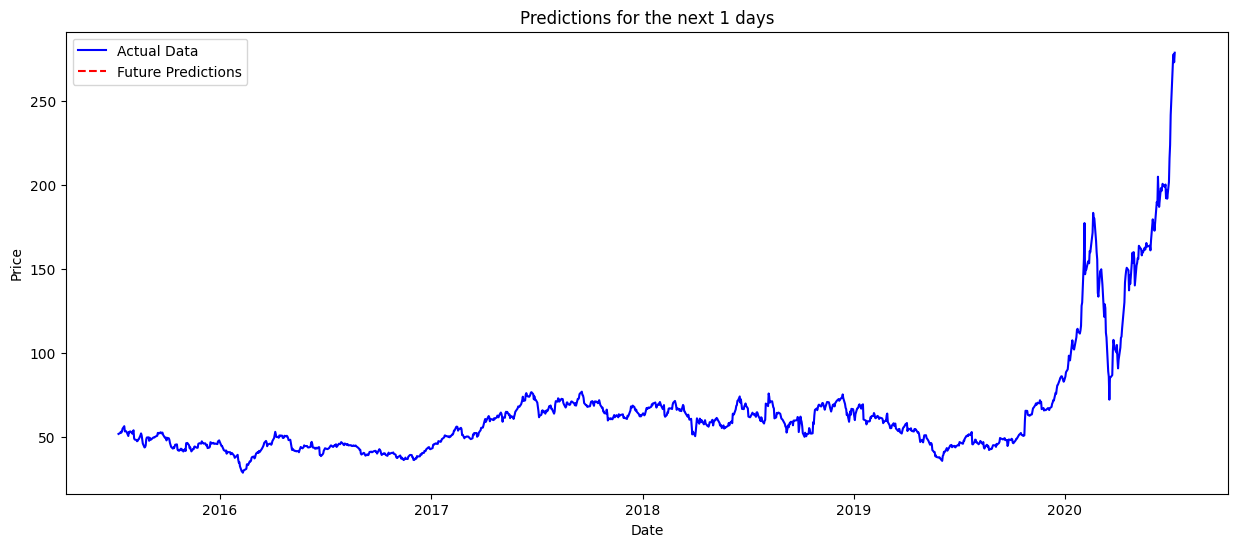

1/1 [==============================] - 0s 20ms/step


<ipython-input-37-174de7bb1ea6>:32: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(latest_date, periods=period + 1, closed='right')


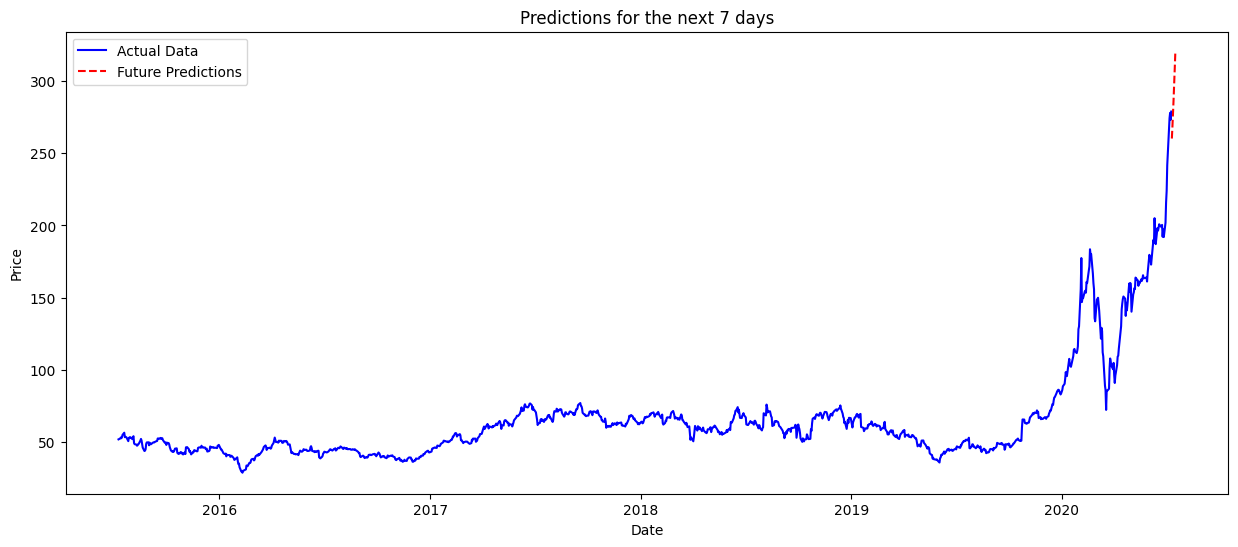

1/1 [==============================] - 0s 19ms/step


<ipython-input-37-174de7bb1ea6>:32: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(latest_date, periods=period + 1, closed='right')


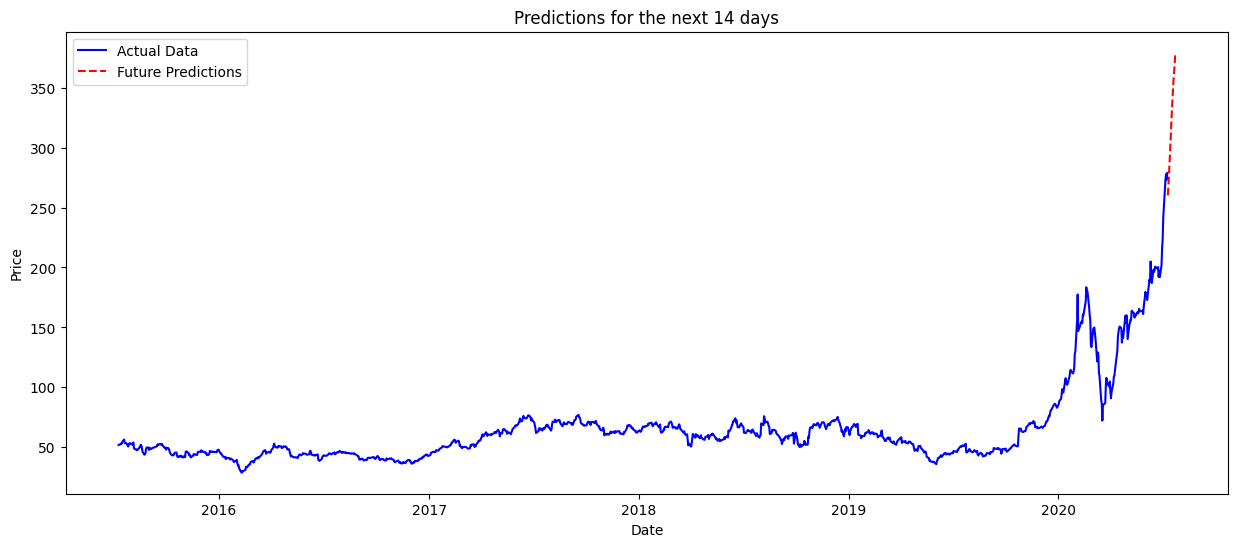

In [37]:
# Define a function to visualize the predictions
def visualize_future_predictions(actual_df, predictions, future_dates, title):
    plt.figure(figsize=(15, 6))
    plt.plot(actual_df.index, actual_df['Close'], label='Actual Data', color='blue')
    plt.plot(future_dates, predictions, label='Future Predictions', color='red', linestyle='dashed')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Train the specific model with a 14-day time step, 4 layers, and a batch size of 64
step = 14
layers = 4
batch = 64
x_all, y_all = create_dataset(scaled_data, step)
x_all = np.reshape(x_all, (x_all.shape[0], x_all.shape[1], 1))
specific_model = build_and_train_model(x_all, y_all, layers, batch, epochs=1)

# Predict the future for 1 day, 1 week, 2 weeks using the specific model
future_periods = [1, 7, 14]
latest_date = df.index[-1]

for period in future_periods:
    last_days_data = scaled_data[-step:].copy()  # Copy to keep original data intact
    for _ in range(period):
        new_pred = specific_model.predict(last_days_data[-step:].reshape(1, step, 1))
        last_days_data = np.append(last_days_data, new_pred)
    future_predictions = scaler.inverse_transform(last_days_data[step:].reshape(-1, 1))

    # Generate future dates for visualization
    future_dates = pd.date_range(latest_date, periods=period + 1, closed='right')

    # Visualize the predictions
    visualize_future_predictions(df, future_predictions, future_dates, f"Predictions for the next {period} days")


In [40]:
future_predictions

array([[265.81737127],
       [275.10581658],
       [285.47652462],
       [296.42348829],
       [308.79197098],
       [321.12383857],
       [334.49637436],
       [347.38265672],
       [359.54611866],
       [371.80269866],
       [383.30267572],
       [392.84717334],
       [403.588669  ],
       [416.20746428]])